## Feature Engineering and Creating Output Label

In [11]:
!pip install xgboost lightgbm

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   - -------------------------------------- 2.4/72.0 MB 18.7 MB/s eta 0:00:04
   - -------------------------------------- 3.4/72.0 MB 8.8 MB/s eta 0:00:08
   -- ------------------------------------- 4.2/72.0 MB 7.2 MB/s eta 0:00:10
   -- ------------------------------------- 5.0/72.0 MB 6.1 MB/s eta 0:00:11
   --- ------------------------------------ 5.8/72.0 MB 5.6 MB/s eta 0:00:12
   --- ------------------------------------ 6.0/72.0 MB 5.1 MB/s eta 0:00:13
   --- ------------------------------------ 6.3/72.0 MB 4.8 MB/s eta 0:00:14
   --- ------------------------------------ 6.6/72.0 MB 4.2 MB/s eta 0:00:16
   --- ------------------------------------ 6.8/72.0 MB 3.7 MB/s eta 0:00:18
   --- ------------------------------------ 7.1/72.0 MB 3.5 MB/s eta 0:00:19
   ---- ----------------------------------- 7.3/72.0 MB 3.4 MB/s eta 0:00:20
   ---- ----------------------------------- 7.6/72.0 MB 3.1 MB/s eta 0:00:21
   --

In [12]:
import os
import pandas as pd
import numpy as np
import fastf1
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_auc_score, roc_curve, precision_recall_curve,
                              average_precision_score, f1_score)
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

os.makedirs('fastf1_cache', exist_ok=True)
fastf1.Cache.enable_cache('fastf1_cache')

In [2]:
RACES_CONFIG = [
    # 2022 Season
    (2022, "Bahrain Grand Prix"),
    (2022, "Saudi Arabian Grand Prix"),
    (2022, "Australian Grand Prix"),
    (2022, "Emilia Romagna Grand Prix"),
    (2022, "Miami Grand Prix"),
    (2022, "Spanish Grand Prix"),
    (2022, "Monaco Grand Prix"),
    (2022, "Azerbaijan Grand Prix"),
    (2022, "Canadian Grand Prix"),
    (2022, "British Grand Prix"),
    (2022, "Austrian Grand Prix"),
    (2022, "French Grand Prix"),
    (2022, "Hungarian Grand Prix"),
    (2022, "Belgian Grand Prix"),
    (2022, "Dutch Grand Prix"),
    (2022, "Italian Grand Prix"),
    (2022, "Singapore Grand Prix"),
    (2022, "Japanese Grand Prix"),
    (2022, "United States Grand Prix"),
    (2022, "Mexico City Grand Prix"),
    (2022, "São Paulo Grand Prix"),
    (2022, "Abu Dhabi Grand Prix"),
    
    # 2023 Season
    (2023, "Bahrain Grand Prix"),
    (2023, "Saudi Arabian Grand Prix"),
    (2023, "Australian Grand Prix"),
    (2023, "Azerbaijan Grand Prix"),
    (2023, "Miami Grand Prix"),
    (2023, "Monaco Grand Prix"),
    (2023, "Spanish Grand Prix"),
    (2023, "Canadian Grand Prix"),
    (2023, "Austrian Grand Prix"),
    (2023, "British Grand Prix"),
    (2023, "Hungarian Grand Prix"),
    (2023, "Belgian Grand Prix"),
    (2023, "Dutch Grand Prix"),
    (2023, "Italian Grand Prix"),
    (2023, "Singapore Grand Prix"),
    (2023, "Japanese Grand Prix"),
    (2023, "Qatar Grand Prix"),
    (2023, "United States Grand Prix"),
    (2023, "Mexico City Grand Prix"),
    (2023, "São Paulo Grand Prix"),
    (2023, "Las Vegas Grand Prix"),
    (2023, "Abu Dhabi Grand Prix"),
    
    # 2024 Season
    (2024, "Bahrain Grand Prix"),
    (2024, "Saudi Arabian Grand Prix"),
    (2024, "Australian Grand Prix"),
    (2024, "Japanese Grand Prix"),
    (2024, "Chinese Grand Prix"),
    (2024, "Miami Grand Prix"),
    (2024, "Emilia Romagna Grand Prix"),
    (2024, "Monaco Grand Prix"),
    (2024, "Canadian Grand Prix"),
    (2024, "Spanish Grand Prix"),
    (2024, "Austrian Grand Prix"),
    (2024, "British Grand Prix"),
    (2024, "Hungarian Grand Prix"),
    (2024, "Belgian Grand Prix"),
    (2024, "Dutch Grand Prix"),
    (2024, "Italian Grand Prix"),
    (2024, "Azerbaijan Grand Prix"),
    (2024, "Singapore Grand Prix"),
]

EVAL_WINDOW = 5
MAX_ACCEPTABLE_LOSS = 2
MIN_VALID_LAPS = 3

In [3]:
def decode_track_status(status_code):
    """Returns (is_safety_car, is_yellow, is_clear, description)"""
    if pd.isna(status_code):
        return False, False, True, "Unknown"
    
    status = int(status_code)
    is_safety_car = any([status == 4, status == 6, status == 7, 
                         '4' in str(status), '6' in str(status)])
    is_yellow = '2' in str(status) and not is_safety_car
    is_clear = status == 1
    
    if status == 1:
        desc = "AllClear"
    elif status == 1254:
        desc = "FormationLap"
    elif is_safety_car:
        desc = "SafetyCar"
    elif is_yellow:
        desc = "Yellow"
    else:
        desc = f"Status_{status}"
    
    return is_safety_car, is_yellow, is_clear, desc

In [4]:
def get_position_before_pit(pit_row, all_laps_df):
    """Get driver position on lap before pit"""
    driver = pit_row['Driver']
    lap_num = pit_row['LapNumber']
    driver_laps = all_laps_df[all_laps_df['Driver'] == driver].set_index('LapNumber').sort_index()
    
    prev_lap = lap_num - 1
    return driver_laps.loc[prev_lap, 'Position'] if prev_lap in driver_laps.index else np.nan

def get_valid_laps_after_pit(pit_row, all_laps_df, eval_window=5):
    """Get list of valid lap numbers after pit (excluding pit/deleted/SC laps)"""
    driver = pit_row['Driver']
    pit_lap = pit_row['LapNumber']
    driver_laps = all_laps_df[all_laps_df['Driver'] == driver].set_index('LapNumber').sort_index()
    
    valid_laps = []
    for lap_num in range(int(pit_lap) + 1, int(pit_lap) + eval_window + 1):
        if lap_num not in driver_laps.index:
            break
        
        lap_data = driver_laps.loc[lap_num]
        if pd.notna(lap_data['PitInTime']) or pd.notna(lap_data['PitOutTime']):
            continue
        if lap_data['Deleted']:
            continue
        
        is_sc, _, _, _ = decode_track_status(lap_data['TrackStatus'])
        if is_sc:
            continue
        
        valid_laps.append(lap_num)
    
    return valid_laps


def calculate_position_after_pit(pit_row, all_laps_df, eval_window=5):
    driver = pit_row['Driver']
    valid_lap_nums = get_valid_laps_after_pit(pit_row, all_laps_df, eval_window)
    
    if not valid_lap_nums:
        return np.nan, 0
    
    driver_laps = all_laps_df[all_laps_df['Driver'] == driver].set_index('LapNumber')
    positions = [driver_laps.loc[ln, 'Position'] for ln in valid_lap_nums 
                 if pd.notna(driver_laps.loc[ln, 'Position'])]
    
    return (np.mean(positions), len(positions)) if positions else (np.nan, 0)


def create_label(pos_before, pos_after, max_loss=2):
    """Label=1 if position maintained or lost <=max_loss, else 0"""
    if pd.isna(pos_before) or pd.isna(pos_after):
        return np.nan
    return 1 if (pos_after - pos_before) <= max_loss else 0

In [5]:
def process_single_race(year, gp_name, eval_window=5, max_loss=2):
    try:
        session = fastf1.get_session(year, gp_name, 'R')
        session.load(telemetry=False, laps=True, weather=False)
    except Exception as e:
        print(f"Failed: {year} {gp_name} - {e}")
        return None
    
    laps = session.laps.copy()
    pit_laps = laps[(laps['PitInTime'].notna()) | (laps['PitOutTime'].notna())].copy()
    
    # Decode track status
    for idx, row in pit_laps.iterrows():
        is_sc, is_yellow, _, desc = decode_track_status(row['TrackStatus'])
        pit_laps.at[idx, 'IsSafetyCarPit'] = is_sc
        pit_laps.at[idx, 'IsYellowFlagPit'] = is_yellow
        pit_laps.at[idx, 'TrackStatusDescription'] = desc
    
    results = []
    for idx, pit_row in pit_laps.iterrows():
        pos_before = get_position_before_pit(pit_row, laps)
        pos_after, num_valid = calculate_position_after_pit(pit_row, laps, eval_window)
        pos_change = pos_after - pos_before if pd.notna(pos_before) and pd.notna(pos_after) else np.nan
        label = create_label(pos_before, pos_after, max_loss)
        
        row_data = {
            'Race': session.event['EventName'],
            'Year': session.event['EventDate'].year,
            'Circuit': session.event['Location'],
            'Driver': pit_row['Driver'],
            'DriverNumber': pit_row['DriverNumber'],
            'Team': pit_row['Team'],
            'LapNumber': pit_row['LapNumber'],
            'PositionBefore': pos_before,
            'PositionAfter': pos_after,
            'PositionChange': pos_change,
            'ValidLapsEvaluated': num_valid,
            'Compound': pit_row['Compound'],
            'TyreLife': pit_row['TyreLife'],
            'FreshTyre': pit_row['FreshTyre'],
            'TrackStatus': pit_row['TrackStatus'],
            'IsSafetyCarPit': pit_row['IsSafetyCarPit'],
            'IsYellowFlagPit': pit_row['IsYellowFlagPit'],
            'TotalRaceLaps': laps['LapNumber'].max(),
            'RaceProgress': pit_row['LapNumber'] / laps['LapNumber'].max(),
            'Label': label
        }
        results.append(row_data)
    
    pit_laps_df = pd.DataFrame(results)
    
    # Filter out SC pits
    pit_laps_df = pit_laps_df[~pit_laps_df['IsSafetyCarPit']]
    pit_laps_df = pit_laps_df[pit_laps_df['ValidLapsEvaluated'] >= MIN_VALID_LAPS]
    pit_laps_df = pit_laps_df[pit_laps_df['Label'].notna()]
    
    return pit_laps_df

In [6]:
def process_all_races(races_list):
    all_pit_laps = []
    
    for i, (year, gp_name) in enumerate(races_list, 1):
        print(f"[{i}/{len(races_list)}] {year} {gp_name}")
        pit_laps_df = process_single_race(year, gp_name, EVAL_WINDOW, MAX_ACCEPTABLE_LOSS)
        
        if pit_laps_df is not None and len(pit_laps_df) > 0:
            all_pit_laps.append(pit_laps_df)
    
    combined_df = pd.concat(all_pit_laps, ignore_index=True)
    print(f"\nTotal: {len(combined_df)} pit stops from {len(all_pit_laps)} races")
    print(f"Label distribution: {combined_df['Label'].value_counts().to_dict()}")
    
    return combined_df

In [7]:
TRACK_OVERTAKING = {
    'Sakhir': 'Easy',
    'Jeddah': 'Easy',
    'Melbourne': 'Medium',
    'Imola': 'Hard',
    'Miami': 'Medium',
    'Barcelona': 'Medium',
    'Monaco': 'Very Hard',
    'Baku': 'Easy',
    'Montréal': 'Medium',
    'Silverstone': 'Easy',
    'Spielberg': 'Easy',
    'Le Castellet': 'Medium',
    'Hungaroring': 'Hard',
    'Spa-Francorchamps': 'Easy',
    'Zandvoort': 'Hard',
    'Monza': 'Easy',
    'Marina Bay': 'Hard',
    'Suzuka': 'Hard',
    'Austin': 'Easy',
    'Mexico City': 'Medium',
    'Interlagos': 'Medium',
    'Las Vegas': 'Easy',
    'Yas Marina': 'Medium',
    'Shanghai': 'Easy',
    'Lusail': 'Easy',
}

TRACK_PIT_LOSS = {
    'Monaco': 18,
    'Zandvoort': 14,
    'Hungaroring': 20,
    'Marina Bay': 22,
    'Barcelona': 20,
    'Suzuka': 21,
    'Imola': 18,
    'Montréal': 15,
    'Baku': 22,
    'Melbourne': 20,
    'Silverstone': 18,
    'Sakhir': 20,
    'Jeddah': 19,
    'Austin': 19,
    'Interlagos': 19,
    'Yas Marina': 20,
    'Spa-Francorchamps': 17,
    'Spielberg': 18,
    'Monza': 16,
    'Mexico City': 20,
    'Miami': 18,
    'Le Castellet': 19,
    'Shanghai': 21,
    'Las Vegas': 17,
    'Lusail': 20,
}

In [8]:
def add_track_features(df):
    """Add track characteristic features"""
    df['OvertakingDifficulty'] = df['Circuit'].map(TRACK_OVERTAKING).fillna('Medium')
    df['PitLossSeconds'] = df['Circuit'].map(TRACK_PIT_LOSS).fillna(19)
    
    # Encode overtaking difficulty
    overtaking_map = {'Very Hard': 0, 'Hard': 1, 'Medium': 2, 'Easy': 3}
    df['OvertakingDifficulty_Numeric'] = df['OvertakingDifficulty'].map(overtaking_map)
    
    return df


def add_position_features(df):
    """Add position-related features"""
    df['PositionGapToLeader'] = df['PositionBefore'] - 1
    df['IsLeader'] = (df['PositionBefore'] == 1).astype(int)
    df['IsTopThree'] = (df['PositionBefore'] <= 3).astype(int)
    df['IsMidfield'] = ((df['PositionBefore'] >= 6) & (df['PositionBefore'] <= 15)).astype(int)
    df['IsBackmarker'] = (df['PositionBefore'] > 15).astype(int)
    
    return df


def add_tire_features(df):
    """Add tire strategy features"""
    # Tire age categories
    df['TyreLife_Category'] = pd.cut(df['TyreLife'], 
                                      bins=[0, 10, 25, 50, 100], 
                                      labels=['Fresh', 'Good', 'Worn', 'Very_Worn'])
    
    # Compound encoding
    compound_map = {'SOFT': 1, 'MEDIUM': 2, 'HARD': 3}
    df['Compound_Numeric'] = df['Compound'].map(compound_map).fillna(2)
    
    return df


def add_race_phase_features(df):
    df['EarlyRace'] = (df['RaceProgress'] < 0.33).astype(int)
    df['MidRace'] = ((df['RaceProgress'] >= 0.33) & (df['RaceProgress'] < 0.67)).astype(int)
    df['LateRace'] = (df['RaceProgress'] >= 0.67).astype(int)
    df['LapsToEnd'] = df['TotalRaceLaps'] - df['LapNumber']
    
    return df


def add_strategic_features(df):
    # Stint length (approximation based on tire life)
    df['EstimatedStintLength'] = df['TyreLife']
    
    # Pit window (typical pit window is laps 15-45 in a 50-60 lap race)
    df['InTypicalPitWindow'] = ((df['LapNumber'] >= 15) & 
                                 (df['LapNumber'] <= df['TotalRaceLaps'] * 0.75)).astype(int)
    
    return df

In [9]:
def engineer_features(df):
    """Apply all feature engineering transformations"""
    df = add_track_features(df)
    df = add_position_features(df)
    df = add_tire_features(df)
    df = add_race_phase_features(df)
    df = add_strategic_features(df)
    
    return df

In [10]:
print("Starting data collection...")
raw_data = process_all_races(RACES_CONFIG)

print("\nApplying feature engineering...")
final_data = engineer_features(raw_data)

print(f"\nFinal dataset shape: {final_data.shape}")
print(f"Features: {final_data.columns.tolist()}")

Starting data collection...
[1/62] 2022 Bahrain Grand Prix


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached da

[2/62] 2022 Saudi Arabian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 22
core        WARNING 	No lap data for driver 47
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 22)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '31', '4', '10', '20', '44', '24', '27', '18', '23', '77', '14', '3', '6', '22', '47']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached dat

[3/62] 2022 Australian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.140000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '63', '44', '4', '3', '31', '77', '10', '23', '24', '18', '47', '20', '22', '6', '14', '1', '5', '55']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[4/62] 2022 Emilia Romagna Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '4', '63', '77', '16', '22', '5', '20', '18', '23', '10', '44', '31', '24', '6', '47', '3', '14', '55']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[5/62] 2022 Miami Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '44', '77', '31', '23', '18', '14', '22', '3', '6', '47', '20', '5', '10', '4', '24']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[6/62] 2022 Spanish Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '55', '44', '77', '31', '4', '14', '22', '5', '3', '10', '47', '18', '6', '20', '23', '24', '16']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[7/62] 2022 Monaco Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '11'
core        WARNING 	Fixed incorrect tyre stint information for driver '55'
core        WARNING 	Fixed incorrect tyre stint information for driver '1'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	Fixed incorrect tyre stint information for driver '63'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '14'
core        WARNING 	Fixed incorrect tyre stint information for driver '44'
core        WARNING 	Fixed incorrect tyre stin

[8/62] 2022 Azerbaijan Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '44', '10', '5', '14', '3', '4', '31', '77', '23', '22', '47', '6', '18', '20', '24', '16', '55']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[9/62] 2022 Canadian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '44', '63', '16', '31', '77', '24', '14', '18', '3', '5', '23', '10', '4', '6', '20', '22', '47', '11']
core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[10/62] 2022 British Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[11/62] 2022 Austrian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	Fixed incorrect tyre stint information for driver '1'
core        WARNING 	Fixed incorrect tyre stint information for driver '44'
core        WARNING 	Fixed incorrect tyre stint information for driver '63'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '47'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '20'
core        WARNING 	Fixed incorrect tyre stin

[12/62] 2022 French Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.041000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '14', '4', '31', '3', '18', '5', '10', '23', '77', '47', '24', '6', '20', '16', '22']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[13/62] 2022 Hungarian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '55', '11', '16', '4', '14', '31', '5', '18', '10', '24', '47', '3', '20', '23', '6', '22', '77']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[14/62] 2022 Belgian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '10'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '63', '14', '16', '31', '5', '10', '23', '18', '4', '22', '24', '3', '20', '47', '6', '77', '44']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[15/62] 2022 Dutch Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '44', '11', '14', '4', '55', '31', '18', '10', '23', '47', '5', '20', '24', '3', '6', '77', '22']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[16/62] 2022 Italian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[17/62] 2022 Singapore Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '4', '3', '18', '1', '5', '44', '10', '77', '20', '47', '63', '22', '31', '23', '14', '6', '24']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[18/62] 2022 Japanese Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '31', '44', '5', '14', '63', '6', '4', '3', '18', '22', '20', '77', '24', '47', '10', '55', '23']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[19/62] 2022 United States Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '11', '63', '4', '14', '5', '20', '22', '31', '24', '23', '10', '47', '3', '6', '18', '77', '55']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[20/62] 2022 Mexico City Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '11', '63', '55', '16', '3', '31', '4', '77', '10', '23', '24', '5', '18', '47', '20', '6', '14', '22']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[21/62] 2022 São Paulo Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '55', '16', '14', '1', '11', '31', '77', '18', '5', '24', '47', '10', '23', '6', '22', '4', '20', '3']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[22/62] 2022 Abu Dhabi Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '55', '63', '4', '31', '18', '3', '5', '22', '24', '23', '10', '77', '47', '20', '44', '6', '14']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[23/62] 2023 Bahrain Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[24/62] 2023 Saudi Arabian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 11 completed the race distance 00:00.035000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '14', '63', '44', '55', '16', '31', '10', '20', '22', '27', '24', '21', '81', '2', '4', '77', '23', '18']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[25/62] 2023 Australian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[26/62] 2023 Azerbaijan Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '16', '14', '55', '44', '18', '63', '4', '22', '81', '23', '20', '10', '31', '2', '27', '77', '24', '21']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[27/62] 2023 Miami Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[28/62] 2023 Monaco Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[29/62] 2023 Spanish Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.037000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[30/62] 2023 Canadian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '44', '16', '55', '11', '23', '31', '18', '77', '81', '10', '4', '22', '27', '24', '20', '21', '63', '2']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[31/62] 2023 Austrian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '4', '14', '55', '63', '44', '18', '10', '23', '24', '2', '31', '77', '81', '21', '20', '22', '27']
core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[32/62] 2023 British Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[33/62] 2023 Hungarian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '44', '81', '63', '16', '55', '14', '18', '23', '77', '3', '27', '22', '24', '20', '2', '31', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[34/62] 2023 Belgian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '44', '14', '63', '4', '31', '18', '22', '10', '77', '24', '23', '20', '3', '2', '27', '55', '81']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[35/62] 2023 Dutch Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:02.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[36/62] 2023 Italian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 06:25.888000 before the recorded end of the session.
core        WARNING 	Driver 11 completed the race distance 06:19.824000 before the recorded end of the session.
core        WARNING 	Driver 55 completed the race distance 06:14.695000 before the recorded end of the session.
core        WARNING 	Driver 16 completed the race distance 06:14.511000 before the recorded end of the session.
core        WARNING 	Driver 63 completed the race distance 06:07.860000 before the recorded end of the session.
core        WARNING 	Driver 

[37/62] 2023 Singapore Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '44', '16', '1', '10', '81', '11', '40', '20', '23', '24', '27', '2', '14', '63', '77', '31', '22', '18']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[38/62] 2023 Japanese Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.076000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '55', '63', '14', '31', '10', '40', '22', '24', '27', '20', '23', '2', '18', '11', '77']


[39/62] 2023 Qatar Grand Prix


events      WARNING 	Correcting user input 'Qatar Grand Prix' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '63', '16', '14', '31', '77', '24', '11', '18', '10', '23', '20', '22', '27', '40', '2', '44', '

[40/62] 2023 United States Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '14', '81', '31', '44', '16']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[41/62] 2023 Mexico City Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '55', '4', '63', '3', '81', '23', '31', '10', '22', '27', '24', '77', '2', '18', '14', '20', '11']


[42/62] 2023 São Paulo Grand Prix


core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '14', '11', '18', '55', '10', '44', '22', '31', '2', '27', '3', '81', '63', '77', '24', '20', '23', '16']
core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[43/62] 2023 Las Vegas Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.001000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '31', '18', '55', '44', '63', '14', '81', '10', '23', '20', '3', '24', '2', '77', '22', '27', '4']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[44/62] 2023 Abu Dhabi Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '11', '4', '81', '14', '22', '44', '18', '3', '31', '10', '23', '27', '2', '24', '55', '77', '20']


[45/62] 2024 Bahrain Grand Prix


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached dat

[46/62] 2024 Saudi Arabian Grand Prix


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


[47/62] 2024 Australian Grand Prix


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


[48/62] 2024 Japanese Grand Prix


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[49/62] 2024 Chinese Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:08.313000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '16', '55', '63', '14', '81', '44', '27', '31', '23', '10', '24', '18', '20', '2', '3', '22', '77']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[50/62] 2024 Miami Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '11', '55', '44', '22', '63', '14', '31', '27', '10', '81', '24', '3', '77', '18', '23', '20', '2']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[51/62] 2024 Emilia Romagna Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '81', '55', '44', '63', '11', '18', '22', '27', '20', '3', '31', '24', '10', '2', '77', '14', '23']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extende

[52/62] 2024 Monaco Grand Prix


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


[53/62] 2024 Canadian Grand Prix


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


[54/62] 2024 Spanish Grand Prix


req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[55/62] 2024 Austrian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']
core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[56/62] 2024 British Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[57/62] 2024 Hungarian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[58/62] 2024 Belgian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '14'
core        WARNING 	Fixed incorrect tyre stint information for driver '3'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']


[59/62] 2024 Dutch Grand Prix


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[60/62] 2024 Italian Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


[61/62] 2024 Azerbaijan Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _ext

[62/62] 2024 Singapore Grand Prix


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']



Total: 3183 pit stops from 62 races
Label distribution: {1.0: 1667, 0.0: 1516}

Applying feature engineering...

Final dataset shape: (3183, 36)
Features: ['Race', 'Year', 'Circuit', 'Driver', 'DriverNumber', 'Team', 'LapNumber', 'PositionBefore', 'PositionAfter', 'PositionChange', 'ValidLapsEvaluated', 'Compound', 'TyreLife', 'FreshTyre', 'TrackStatus', 'IsSafetyCarPit', 'IsYellowFlagPit', 'TotalRaceLaps', 'RaceProgress', 'Label', 'OvertakingDifficulty', 'PitLossSeconds', 'OvertakingDifficulty_Numeric', 'PositionGapToLeader', 'IsLeader', 'IsTopThree', 'IsMidfield', 'IsBackmarker', 'TyreLife_Category', 'Compound_Numeric', 'EarlyRace', 'MidRace', 'LateRace', 'LapsToEnd', 'EstimatedStintLength', 'InTypicalPitWindow']


In [11]:
print("\nData Quality Check:")
print(f"Missing values per column:")
print(final_data.isnull().sum()[final_data.isnull().sum() > 0])

print(f"\nLabel distribution:")
print(final_data['Label'].value_counts())
print(f"Effectiveness rate: {final_data['Label'].mean():.1%}")


Data Quality Check:
Missing values per column:
TyreLife                28
TyreLife_Category       28
EstimatedStintLength    28
dtype: int64

Label distribution:
Label
1.0    1667
0.0    1516
Name: count, dtype: int64
Effectiveness rate: 52.4%


In [12]:
feature_columns = [
    #Position features
    'PositionBefore', 'PositionGapToLeader', 'IsLeader', 'IsTopThree', 
    'IsMidfield', 'IsBackmarker',
    #Tyre features
    'TyreLife', 'Compound_Numeric', 'FreshTyre',  
    #Race phase features
    'RaceProgress', 'EarlyRace', 'MidRace', 'LateRace', 'LapsToEnd',
    #Track features
    'OvertakingDifficulty_Numeric', 'PitLossSeconds',
    #Strategic features
    'EstimatedStintLength', 'InTypicalPitWindow',
    #Context
    'Year'
]

X = final_data[feature_columns].copy()
y = final_data['Label'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures for modeling:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")


Feature matrix shape: (3183, 19)
Target vector shape: (3183,)

Features for modeling:
1. PositionBefore
2. PositionGapToLeader
3. IsLeader
4. IsTopThree
5. IsMidfield
6. IsBackmarker
7. TyreLife
8. Compound_Numeric
9. FreshTyre
10. RaceProgress
11. EarlyRace
12. MidRace
13. LateRace
14. LapsToEnd
15. OvertakingDifficulty_Numeric
16. PitLossSeconds
17. EstimatedStintLength
18. InTypicalPitWindow
19. Year


In [13]:
final_data.to_csv('pit_stops_engineered.csv', index=False)
X.to_csv('features_X.csv', index=False)
y.to_csv('target_y.csv', index=False)
print("\nData saved.")


Data saved.


## Data Preparation (filling missing values and T-T-S)

In [6]:
X = pd.read_csv('features_X.csv')
y = pd.read_csv('target_y.csv').values.ravel()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Label distribution: {pd.Series(y).value_counts().to_dict()}")

Features shape: (3183, 19)
Target shape: (3183,)
Label distribution: {1.0: 1667, 0.0: 1516}


In [7]:
# Handle Missing Values
print(f"Missing values check:")
print(X.isnull().sum()[X.isnull().sum() > 0])

# Handle any missing values if they exist
if X.isnull().sum().sum() > 0:
    X = X.fillna({
        'TyreLife': X['TyreLife'].median(),
        'EstimatedStintLength': X['EstimatedStintLength'].median()
    })
    print(f"\nMissing values after imputation: {X.isnull().sum().sum()}")
else:
    print("No missing values found.")

Missing values check:
TyreLife                28
EstimatedStintLength    28
dtype: int64

Missing values after imputation: 0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Label distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Test set: {X_test.shape}, Label distribution: {pd.Series(y_test).value_counts().to_dict()}")


Train set: (2546, 19), Label distribution: {1.0: 1333, 0.0: 1213}
Test set: (637, 19), Label distribution: {1.0: 334, 0.0: 303}


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [13]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}
# i tested all these classification models and choose the best model

## Cross Validation

In [14]:
def evaluate_model_cv(model, X, y, cv=5):
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    scores = {
        'accuracy': cross_val_score(model, X, y, cv=cv_strategy, scoring='accuracy').mean(),
        'f1': cross_val_score(model, X, y, cv=cv_strategy, scoring='f1').mean(),
        'roc_auc': cross_val_score(model, X, y, cv=cv_strategy, scoring='roc_auc').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_strategy, scoring='precision').mean(),
        'recall': cross_val_score(model, X, y, cv=cv_strategy, scoring='recall').mean()
    }
    
    return scores

## Training and Evaluating Models

In [15]:
print("\nTraining and evaluating models...\n")

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for Logistic Regression
    if name == 'Logistic Regression':
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    # Train
    model.fit(X_tr, y_train)
    
    # Predict
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]
    
    # Evaluate
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'accuracy': (y_pred == y_test).mean(),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'precision': classification_report(y_test, y_pred, output_dict=True)['1.0']['precision'],
        'recall': classification_report(y_test, y_pred, output_dict=True)['1.0']['recall']
    }
    
    print(f"  Accuracy: {results[name]['accuracy']:.4f}")
    print(f"  F1 Score: {results[name]['f1']:.4f}")
    print(f"  ROC-AUC: {results[name]['roc_auc']:.4f}\n")


Training and evaluating models...

Training Logistic Regression...
  Accuracy: 0.7378
  F1 Score: 0.7370
  ROC-AUC: 0.8003

Training Random Forest...
  Accuracy: 0.7614
  F1 Score: 0.7725
  ROC-AUC: 0.8468

Training Gradient Boosting...
  Accuracy: 0.7535
  F1 Score: 0.7639
  ROC-AUC: 0.8542

Training XGBoost...
  Accuracy: 0.7912
  F1 Score: 0.8058
  ROC-AUC: 0.8740

Training LightGBM...


  File "C:\Users\ishaa\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\ishaa\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ishaa\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ishaa\anaconda3\Lib\subprocess.

  Accuracy: 0.7959
  F1 Score: 0.8060
  ROC-AUC: 0.8743



In [16]:
results_df = pd.DataFrame({
    name: {
        'Accuracy': res['accuracy'],
        'F1 Score': res['f1'],
        'ROC-AUC': res['roc_auc'],
        'Precision': res['precision'],
        'Recall': res['recall']
    }
    for name, res in results.items()
}).T

results_df = results_df.sort_values('F1 Score', ascending=False)
print("Model Performance Comparison:")
print(results_df.round(4))

Model Performance Comparison:
                     Accuracy  F1 Score  ROC-AUC  Precision  Recall
LightGBM               0.7959    0.8060   0.8743     0.8036  0.8084
XGBoost                0.7912    0.8058   0.8740     0.7863  0.8263
Random Forest          0.7614    0.7725   0.8468     0.7725  0.7725
Gradient Boosting      0.7535    0.7639   0.8542     0.7674  0.7605
Logistic Regression    0.7378    0.7370   0.8003     0.7774  0.7006


In [18]:
best_model_name = results_df['F1 Score'].idxmax()
best_model = results[best_model_name]['model']

print(f"\nBest model: {best_model_name}")
print(f"F1 Score: {results[best_model_name]['f1']:.4f}")
print(f"ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")

print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y_test, results[best_model_name]['y_pred'], 
                          target_names=['Ineffective', 'Effective']))


Best model: LightGBM
F1 Score: 0.8060
ROC-AUC: 0.8743

Classification Report for LightGBM:
              precision    recall  f1-score   support

 Ineffective       0.79      0.78      0.78       303
   Effective       0.80      0.81      0.81       334

    accuracy                           0.80       637
   macro avg       0.80      0.80      0.80       637
weighted avg       0.80      0.80      0.80       637



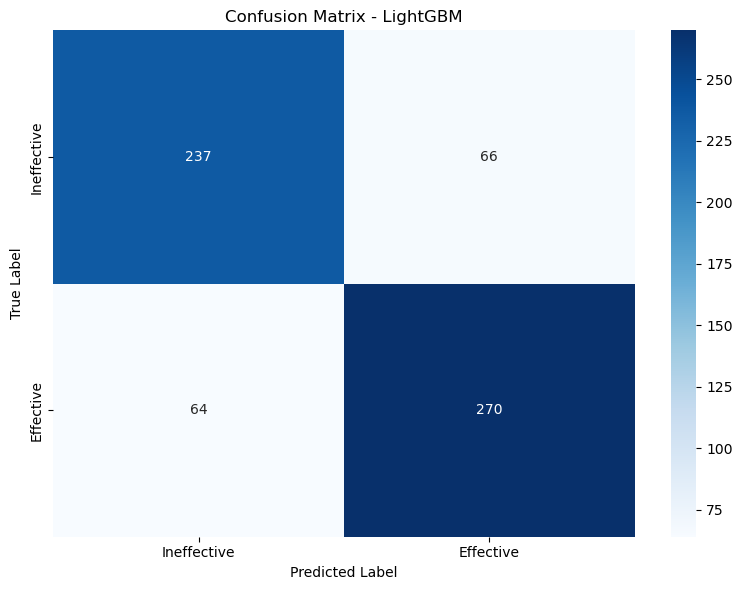


True Negatives: 237, False Positives: 66
False Negatives: 64, True Positives: 270


In [19]:
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ineffective', 'Effective'],
            yticklabels=['Ineffective', 'Effective'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

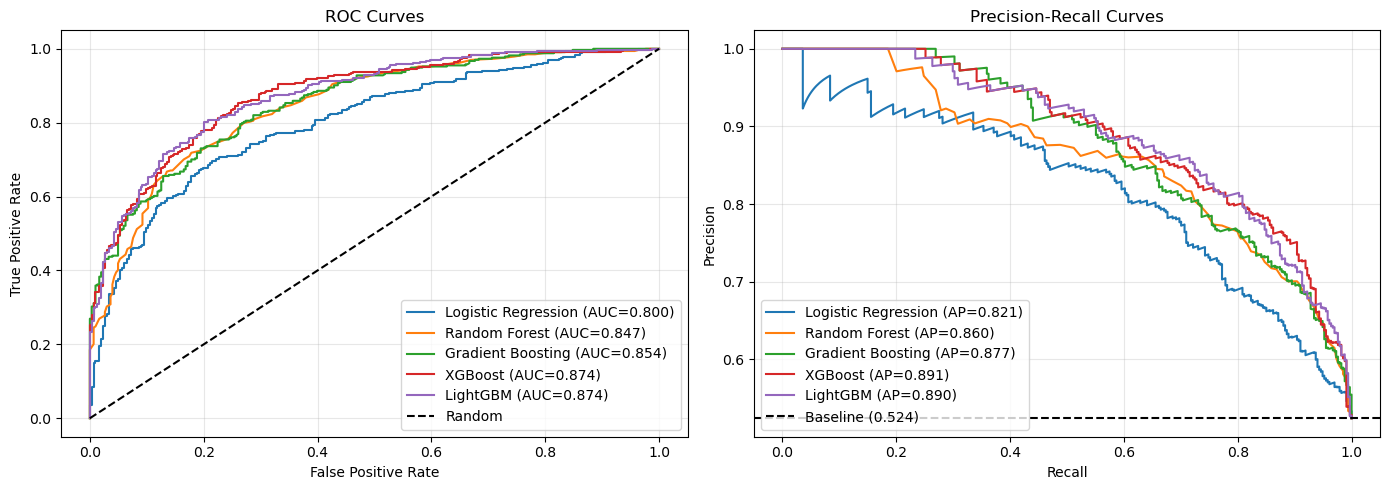

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    ax1.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.3f})")

ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
for name, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res['y_proba'])
    ap = average_precision_score(y_test, res['y_proba'])
    ax2.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

baseline = y_test.mean()
ax2.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

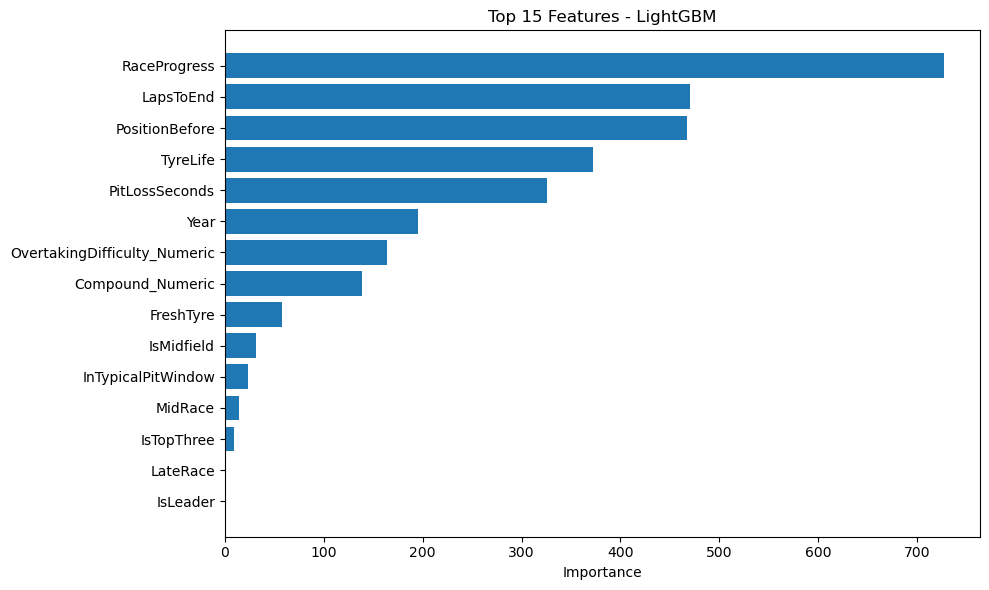


Top 10 Most Important Features:
                     feature  importance
                RaceProgress         727
                   LapsToEnd         470
              PositionBefore         467
                    TyreLife         372
              PitLossSeconds         326
                        Year         195
OvertakingDifficulty_Numeric         164
            Compound_Numeric         139
                   FreshTyre          58
                  IsMidfield          32


In [21]:
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['feature'].head(15), 
                 feature_importance['importance'].head(15))
        plt.xlabel('Importance')
        plt.title(f'Top 15 Features - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))

In [22]:
from sklearn.model_selection import RandomizedSearchCV

print(f"\nHyperparameter tuning for {best_model_name}...")

# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, -1],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 70],
        'subsample': [0.6, 0.8, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0]
    }
}

if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]
    if best_model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif best_model_name == 'XGBoost':
        base_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    elif best_model_name == 'LightGBM':
        base_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    elif best_model_name == 'Gradient Boosting':
        base_model = GradientBoostingClassifier(random_state=42)
    
    # Randomized search
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=20,
        cv=5,
        scoring='f1',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    print(f"\nBest parameters: {random_search.best_params_}")
    print(f"Best CV F1 score: {random_search.best_score_:.4f}")
    
    # Evaluate tuned model
    tuned_model = random_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test)
    y_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]
    
    print(f"\nTuned model performance:")
    print(f"  Accuracy: {(y_pred_tuned == y_test).mean():.4f}")
    print(f"  F1 Score: {f1_score(y_test, y_pred_tuned):.4f}")
    print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_tuned):.4f}")
    
    # Save best model
    best_model = tuned_model


Hyperparameter tuning for LightGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'subsample': 1.0, 'num_leaves': 50, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1}
Best CV F1 score: 0.7604

Tuned model performance:
  Accuracy: 0.8038
  F1 Score: 0.8143
  ROC-AUC: 0.8758


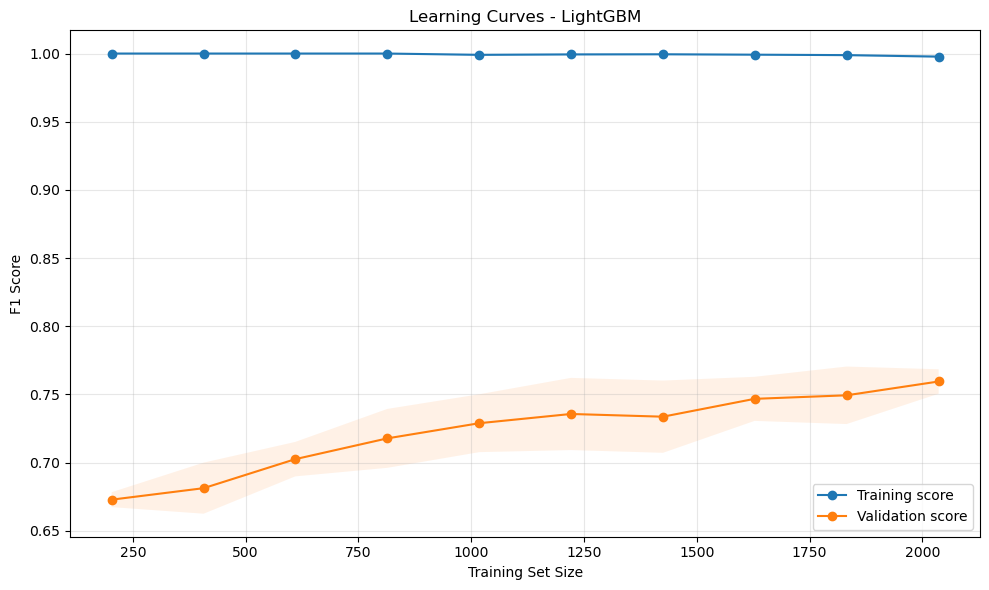

In [23]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', marker='o')
plt.plot(train_sizes, val_mean, label='Validation score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title(f'Learning Curves - {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
import joblib

joblib.dump(best_model, 'best_pitstop_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

model_info = {
    'model_name': best_model_name,
    'f1_score': f1_score(y_test, results[best_model_name]['y_pred']),
    'roc_auc': roc_auc_score(y_test, results[best_model_name]['y_proba']),
    'features': X_train.columns.tolist()
}

pd.DataFrame([model_info]).to_csv('model_info.csv', index=False)
print(f"\nModel saved: best_pitstop_model.pkl")
print(f"Scaler saved: feature_scaler.pkl")
print(f"Model info saved: model_info.csv")



Model saved: best_pitstop_model.pkl
Scaler saved: feature_scaler.pkl
Model info saved: model_info.csv


In [26]:
print(f"\nBest Model: {best_model_name}")
print(f"Test Set Performance:")
print(f"  Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"  F1 Score: {results[best_model_name]['f1']:.4f}")
print(f"  ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"  Precision: {results[best_model_name]['precision']:.4f}")
print(f"  Recall: {results[best_model_name]['recall']:.4f}")
print("\nFiles created:")
print("  - best_pitstop_model.pkl")
print("  - feature_scaler.pkl")
print("  - model_info.csv")


MODELING PIPELINE COMPLETE

Best Model: LightGBM
Test Set Performance:
  Accuracy: 0.7959
  F1 Score: 0.8060
  ROC-AUC: 0.8743
  Precision: 0.8036
  Recall: 0.8084

Files created:
  - best_pitstop_model.pkl
  - feature_scaler.pkl
  - model_info.csv
